# 🧬 Demo: Single-Cell RNA-seq Analysis Workflow

This notebook demonstrates a complete scRNA-seq analysis workflow using the analysis template.

**Goals:**
1. Show how to use the local analysis package
2. Demonstrate which steps to run locally vs. on a GPU cluster (Euler)
3. Illustrate the local ↔ remote sync workflow via Git/GitHub

**Legend:**
- 💻 **Local** — Fast, good for development, code editing
- 🚀 **GPU/Euler** — Heavy compute, model fitting, GPU-accelerated

**Changelog:**
- 2026-01-27: Initial demo notebook

## Preliminaries

### Dependency notebooks

This is a standalone demo — no dependencies on other notebooks.

### Library imports

`autoreload` to re-load packages.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings

import matplotlib.pyplot as plt
import scanpy as sc

# Local analysis package — edit these functions in src/myanalysis/
from myanalysis import FilePaths, qc_violin

warnings.filterwarnings("ignore", category=FutureWarning)

Project root: /Users/mlange/Projects/analysis_template
Data folder:  /Users/mlange/Projects/analysis_template/data


### General settings

In [ ]:
sc.settings.verbosity = 2
sc.settings.datasetdir = FilePaths.EXAMPLE_DATASET / "raw"
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.settings.figdir = FilePaths.FIGURES / "example_dataset"

print(f"Project root: {FilePaths.ROOT}")
print(f"Data folder:  {FilePaths.DATA}")

### Function definitions

Any utility functions specific to this notebook go here. For reusable functions, add them to `src/myanalysis/`.

### Data loading

We'll use the classic PBMC 3k dataset from 10X Genomics, available via scanpy.

In [3]:
# Download PBMC 3k (cached after first download)
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
# Store raw counts for scVI (needs raw integer counts)
adata.layers["counts"] = adata.X.copy()

---

## Main analysis

### 🔬 Quality Control — 💻 Local

QC is fast and benefits from quick iteration — perfect for local development.

In [5]:
# Annotate mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

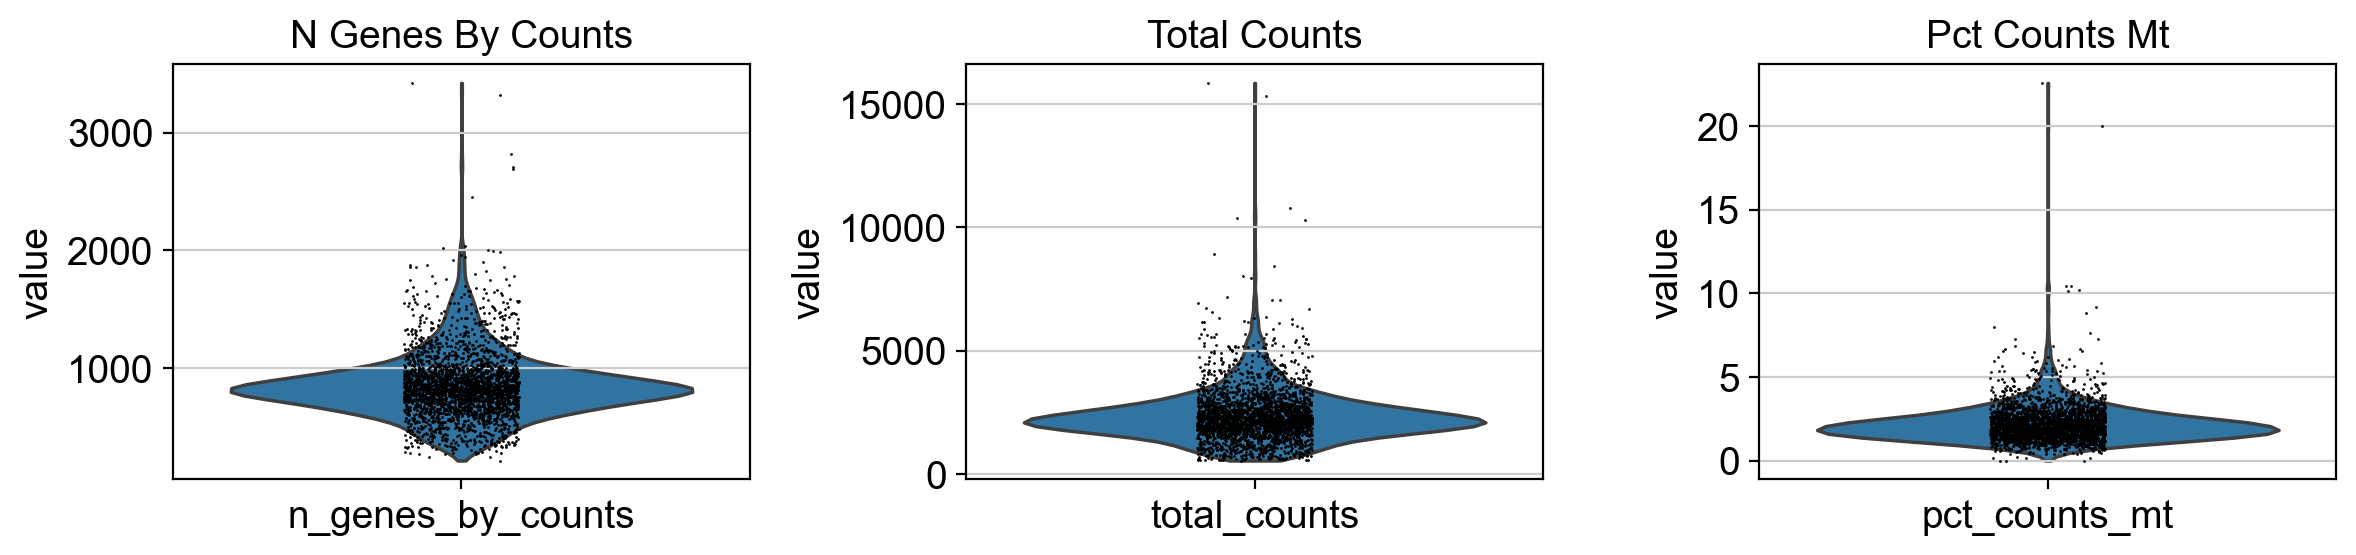

In [6]:
# Use our custom plotting function from the local package!
# 💡 TIP: Edit src/myanalysis/plotting.py locally, then run again, autoreload will update automatically!
fig = qc_violin(adata, figsize=(12, 3))
plt.show()

In [7]:
# Filter cells and genes
print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

print(f"After filtering:  {adata.n_obs} cells, {adata.n_vars} genes")

Before filtering: 2700 cells, 32738 genes
filtered out 19024 genes that are detected in less than 3 cells
After filtering:  2638 cells, 13714 genes


### 🧮 Preprocessing — 💻 Local

Normalization and HVG selection are fast operations.

In [8]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
print(f"Highly variable genes: {adata.var.highly_variable.sum()}")

normalizing counts per cell


/var/folders/j6/fcqzqhwj6y7b1nzw3241zgjw0000gr/T/ipykernel_12501/1339639258.py:2: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata, target_sum=1e4)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:01)
extracting highly variable genes
    finished (0:00:00)
Highly variable genes: 2000


### 🚀 scVI Model Training — 🚀 GPU/Euler

**This section benefits from GPU acceleration!**

Workflow for running on Euler:
1. 💻 Commit & push your notebook: `git add . && git commit -m "Ready for scVI" && git push`
2. 🖥️ SSH to Euler, pull changes: `git pull`
3. 🚀 Run this section in JupyterHub: https://jupyter.euler.hpc.ethz.ch
4. 💾 Save results and push: `git add . && git commit -m "scVI trained" && git push`
5. 💻 Pull results locally: `git pull`

In [9]:
import scvi

# Check if GPU is available
import torch

print(f"PyTorch device: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")
print(f"MPS available (Apple Silicon): {torch.backends.mps.is_available()}")

PyTorch device: CPU
MPS available (Apple Silicon): True


In [10]:
# Setup scVI model
scvi.model.SCVI.setup_anndata(adata, layer="counts")

# Create and train model
# 💡 On GPU: ~1 min | On CPU: ~5-10 min
model = scvi.model.SCVI(adata, n_latent=10, n_layers=2)
model.train(max_epochs=10, early_stopping=True)

/Users/mlange/Projects/analysis_template/.pixi/envs/default/lib/python3.12/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/mlange/Projects/analysis_template/.pixi/envs/default/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/mlange/Projects/analysis_template/.pixi/envs/default/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
# Get latent representation
adata.obsm["X_scVI"] = model.get_latent_representation()
print(f"scVI latent shape: {adata.obsm['X_scVI'].shape}")

scVI latent shape: (2638, 10)


### ⚡ Neighbors & UMAP — 🚀 GPU/Euler (rapids-singlecell)

On Linux with NVIDIA GPU, we can use `rapids-singlecell` for massive speedups.
Falls back to scanpy on macOS.

In [12]:
import sys

# Use rapids-singlecell on Linux (GPU), scanpy on macOS
if sys.platform == "linux":
    try:
        import rapids_singlecell as rsc

        print("✅ Using rapids-singlecell (GPU-accelerated)")
        USE_RAPIDS = True
    except ImportError:
        print("⚠️ rapids-singlecell not available, falling back to scanpy")
        USE_RAPIDS = False
else:
    print("💻 macOS detected, using scanpy (CPU)")
    USE_RAPIDS = False

💻 macOS detected, using scanpy (CPU)


In [13]:
# Compute neighbors and UMAP
# 💡 With rapids on GPU: seconds | With scanpy on CPU: ~30s for 3k cells

if USE_RAPIDS:
    # GPU-accelerated
    rsc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
    rsc.tl.umap(adata)
else:
    # CPU fallback
    sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
    sc.tl.umap(adata)

computing neighbors
    finished (0:00:04)
computing UMAP
    finished (0:00:02)


In [14]:
# Clustering (Leiden)
if USE_RAPIDS:
    rsc.tl.leiden(adata, resolution=0.5, key_added="leiden")
else:
    sc.tl.leiden(adata, resolution=0.5, key_added="leiden", flavor="igraph", n_iterations=2)

print(f"Found {adata.obs['leiden'].nunique()} clusters")

running Leiden clustering
    finished (0:00:00)
Found 11 clusters


### 🎨 Visualization — 💻 Local

Back to local for visualization and figure generation.

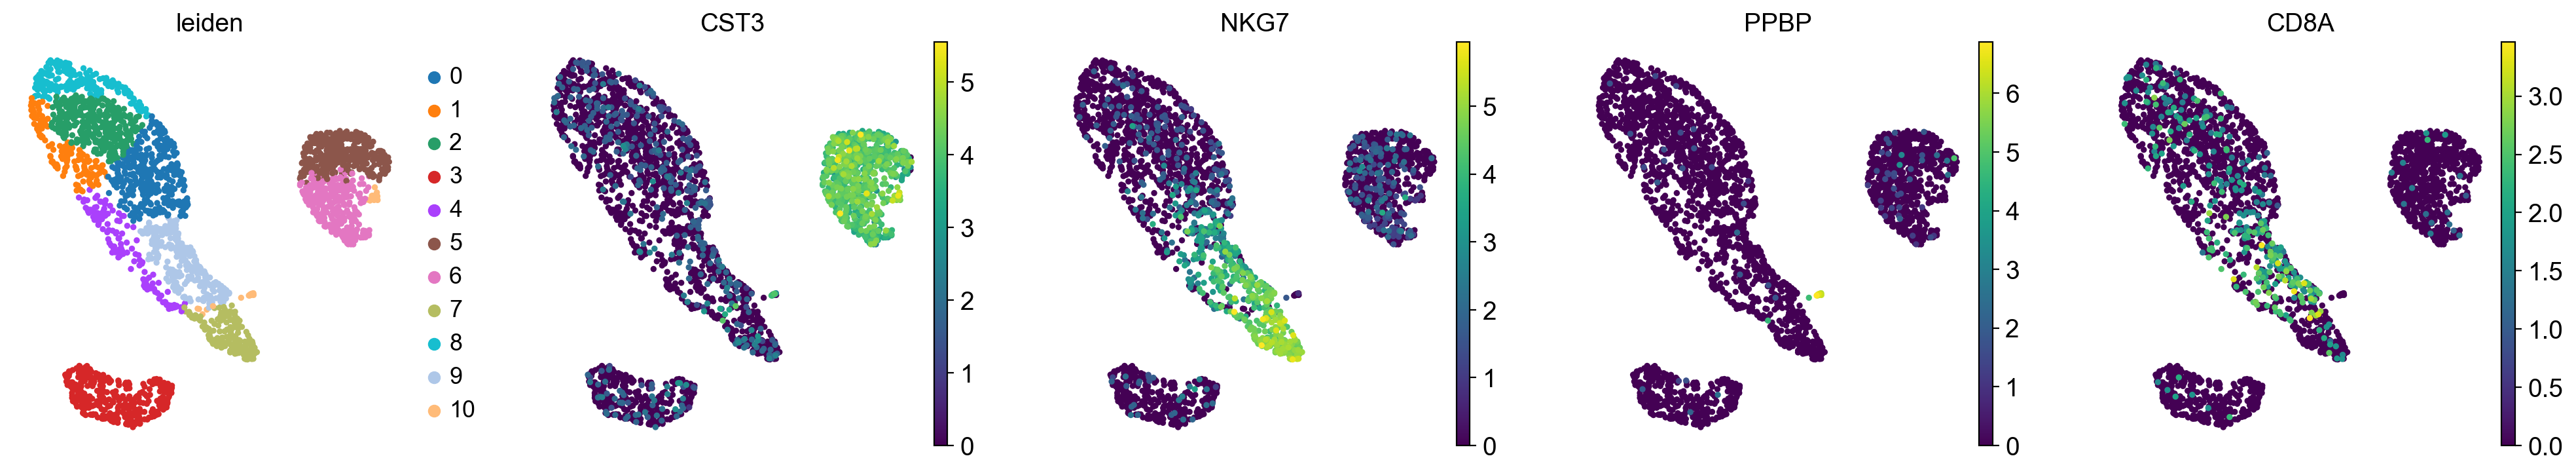

In [24]:
sc.pl.embedding(adata, basis="umap", color=["leiden", "CST3", "NKG7", "PPBP", "CD8A"], ncols=5, save="_overview.png")

### 🏷️ Cell Type Annotation — 💻 Local

Let's first get the model, if we haven't already downloaded it. 

In [16]:
import celltypist
from celltypist import models

models.download_models(model="Immune_All_High.pkl")

📂 Storing models in /Users/mlange/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_High.pkl (file exists)


Now we use the downloaded model for annotation. 

In [17]:
# Load and annotate
model = models.Model.load(model="Immune_All_High.pkl")
predictions = celltypist.annotate(adata, model=model, majority_voting=True)

🔬 Input data has 2638 cells and 13714 genes
🔗 Matching reference genes in the model
🧬 4178 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [18]:
# Add to adata
adata.obs["cell_type"] = predictions.predicted_labels["majority_voting"]
adata.obs["cell_type"].value_counts()

cell_type
T cells                     1457
Monocytes                    654
B cells                      332
ILC                          165
DC                            19
Megakaryocytes/platelets      11
Name: count, dtype: int64

Visualize the umap again. 

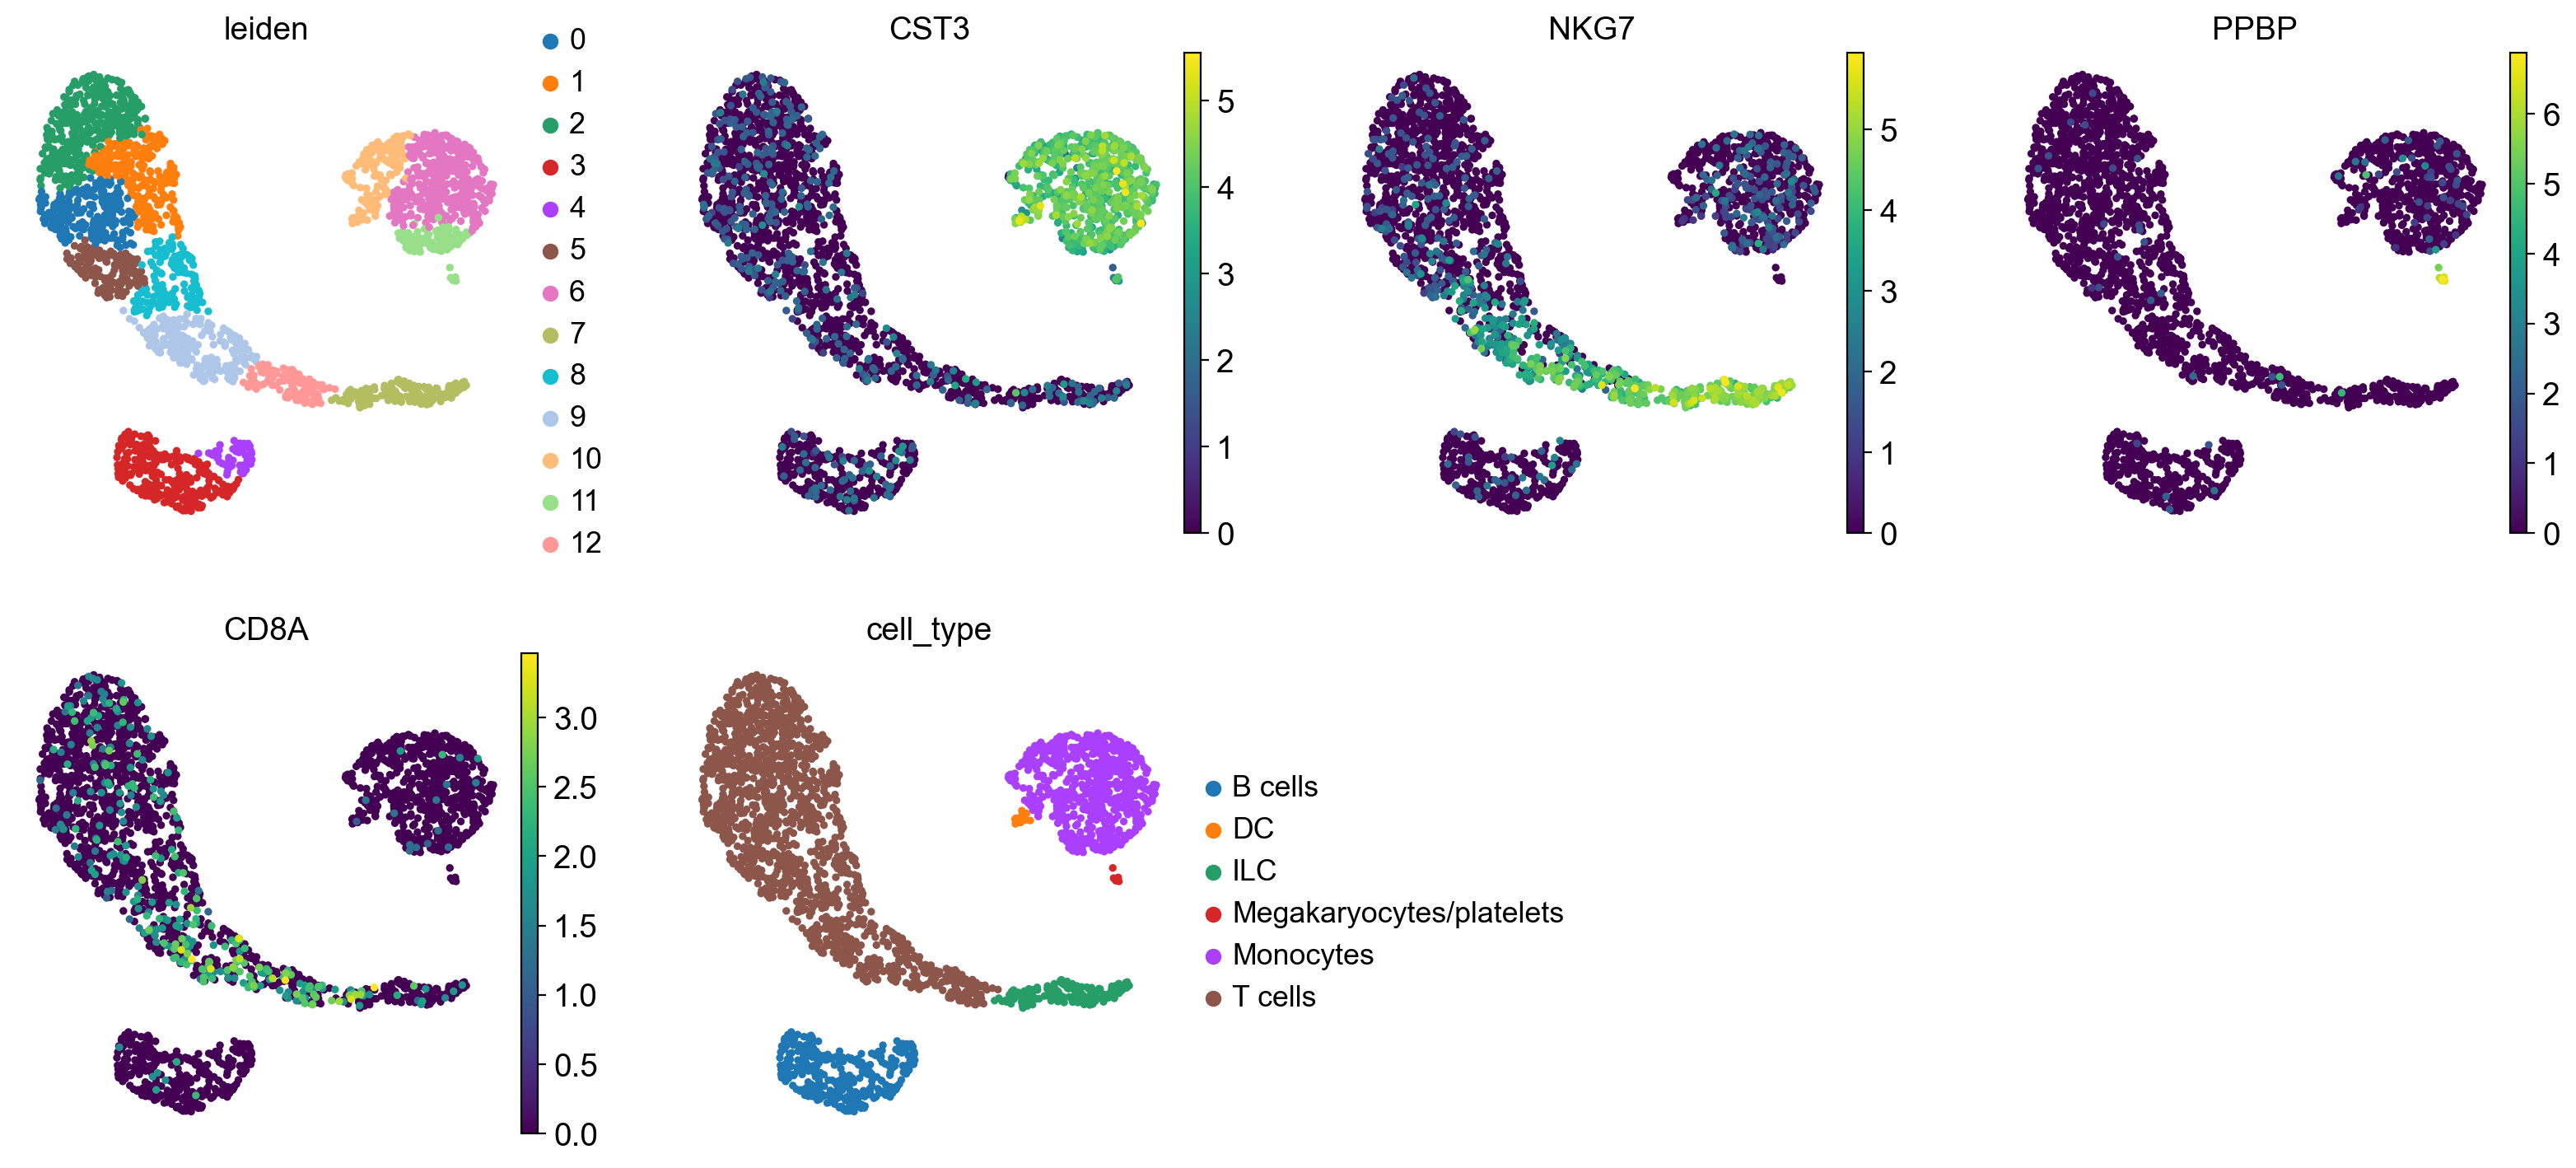

In [19]:
sc.pl.embedding(
    adata,
    basis="umap",
    color=[
        "leiden",
        "CST3",
        "NKG7",
        "PPBP",
        "CD8A",
        "cell_type",
    ],
)

### 💾 Save Results — 💻 Local

Save processed data following the template's data organization.

In [21]:
output_path = FilePaths.EXAMPLE_DATASET / "processed" / "pbmc3k_processed.h5ad"
adata.write(output_path)
print(f"Saved to: {output_path}")

Saved to: /Users/mlange/Projects/analysis_template/data/example_dataset/processed/pbmc3k_processed.h5ad


---

### 📋 Session Info

In [22]:
from session_info2 import session_info

session_info()

Package,Version
pandas,2.3.3
anndata,0.12.8
matplotlib,3.10.8
scanpy,1.12
myanalysis,0.1.dev29+g32849c680.d20260127
scvi-tools,1.4.1
torch,2.10.0
celltypist,1.7.1
Component,Info
Python,"3.12.12 | packaged by conda-forge | (main, Jan 27 2026, 00:01:15) [Clang 19.1.7 ]"


### 🔄 Workflow Summary


**Git sync workflow:**
```bash
# Local: push changes
git add . && git commit -m "description" && git push

# Euler: pull and run
git pull
# ... run heavy compute ...
git add . && git commit -m "results" && git push

# Local: pull results
git pull
```